In [1]:
import pandas as pd
from scipy import stats
# import custom libraries
from tools.glm import (add_regressors, array2dummies,
                       n_back_array, n_back_series,
                       glm, contrast)

df = pd.read_csv("../data/regs_and_rts.csv")

In [2]:
pes = pd.DataFrame()

for (sub, ses, scn), group in df.groupby(["sub", "real_ses", "scn"], as_index=False):
    X = group[["loc1", "loc2", "loc3", "loc4", "lag1_loc", "lag2_loc", "lag1_clr", "lag2_clr"]].astype(float)
    Y = group.norm_rt
    b = glm(Y, X.T)
    
    b[:4] * group[["loc1", "loc2", "loc3", "loc4"]]
    
    baseline = (b[:4] * group[["loc1", "loc2", "loc3", "loc4"]]).sum(axis=1)
    res = Y - baseline
    
    regs = X.columns.tolist()[4:]
    
    rs = []
    for i, reg in enumerate(regs):
        other = regs.copy()
        other.remove(reg)
        
        # Make use of b[i] corresponding to regs[i]
        b_res = list(b[4:])
        b_reg = b_res.pop(i)
        
        yhat_res = (b_res * group[other]).sum(axis=1)
        yhat_reg = (b_reg * group[reg])

        r, p = stats.pearsonr(res - yhat_res, yhat_reg)
        rs.append(r**2)
    
    result = pd.DataFrame([b], columns=["loc1", "loc2", "loc3", "loc4", "lag1_loc", "lag2_loc", "lag1_clr", "lag2_clr"])
    result = result.join(pd.DataFrame([rs], columns=[reg+"_r" for reg in regs]))
    result = result.assign(**{
        "sub": sub,
        "ses": ses,
        "scn": scn,        
    })
    
    pes = pes.append(result)

In [9]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

/home/manje/miniconda3/envs/multi/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


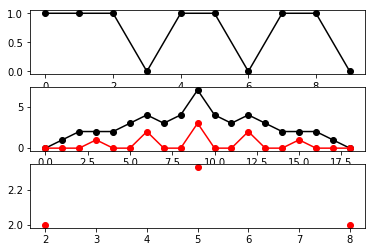

In [62]:
a = np.random.randint(0, 2, 10)
b = 1 - a

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
ax1.plot(a, "ko-")
ax2.plot(signal.correlate(a, a, mode="full"), "ko-")
ax2.plot(signal.correlate(b, b, mode="full"), "ro-")
ax3.plot(signal.correlate(a, a, mode="same") / signal.correlate(b, b, mode="same"), "ro-")

In [63]:
from scipy import stats

In [128]:
r, p = stats.pearsonr(a, np.roll(a, 6))

In [129]:
r

0.04761904761904761

In [108]:
a

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0])

In [110]:
(np.sum((a - np.roll(a, 1))**2) / len(a))**.5

0.7745966692414834

In [85]:
a - np.roll(a, 1)

array([ 1,  0,  0, -1,  1,  0, -1,  1,  0, -1])

In [111]:
(a - np.roll(a, 1))

array([ 1,  0,  0, -1,  1,  0, -1,  1,  0, -1])

In [132]:
a

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0])

In [131]:
np.roll(a, 1) * a

array([0, 1, 1, 0, 0, 1, 0, 0, 1, 0])

In [130]:
(a * np.roll(a, 6)).mean()

0.5

In [135]:
stats.pearsonr(a, np.roll(a, -1))

(-0.4285714285714286, 0.21654728411266919)

In [144]:
(1/(len(a)-1)) * (a - np.roll(a, 2)).sum()

0.0

In [145]:
a - np.roll(a, 2)

array([ 0,  1,  0, -1,  0,  1, -1,  0,  1, -1])

In [146]:
(a - np.roll(a, 2)).sum()

0

In [158]:
np.correlate(np.array([1,0,0,1,0,0,1]), np.array([0,1,0,0,1,0,0]), mode="same")

array([0, 0, 2, 0, 0, 2, 0])